In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [2]:
# function definitions for correlations

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr()
    #values = corr.values
    #cols = corr.columns

    return corr
    # end def correlate_topics

# function for calculating topic correlation
# with slicing by party

def corr_topics(run_id, party_name=None, period=None):
    print("Calculating topic correlation for party {} and period {} in run {}".format(party_name, period, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
        
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    corr = correlate_topics(df, doc_id)
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return corr

In [3]:
# function definitions for creating and plotting graphs 

import networkx as nx

def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    ids = {}
    scores = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        ids[i] = topic.id
        #top_words[i] = ", ".join(topic.top_words)
        scores[i] = topic.score
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, ids, name="id")
    nx.set_node_attributes(G, scores, name="totalscores")

    nx.set_node_attributes(G, top_words, name="topwords")
    
    weights = {}
    for i in range(len(topic_ids)):
        for j in range(len(topic_ids)):
            weights[(i, j)] = float(corr.values[i][j])
    
    nx.set_edge_attributes(G, weights, "weight")

    return G


def show_graph(G):
    
    fig = plt.figure()
    
    #pos=nx.circular_layout(G)
    pos=nx.spring_layout(G)

    #nx.draw_networkx_edges(G, pos)
    #nx.draw_networkx_nodes(G, pos, )
    colors = list(nx.get_node_attributes(G, "totalscore").values())
    
    nx.draw(G, pos, node_color=colors, node_cmap=plt.cm.Blues,
            width=2, edge_cmap=plt.cm.Blues, with_labels=False)

    nx.draw_networkx_labels(G,pos,nx.get_node_attributes(G,"label"),font_size=8)
    
    

    plt.show()
    
def corr_hist(corr, threshold_pct):
    vals = (corr.values - np.identity(corr.shape[0])).flatten()
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=50)
    return threshold

In [4]:
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()

In [5]:
run_id = 2155

# get topic scores per period
dts = DocTopic.objects.filter(run_id=run_id)
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_period_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_period_scores

# get topic scores per party
topic_period_scores = dts.values('topic__title','ut__speaker__party__name').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'party']
df_party_scores = df.pivot(index='party', columns='topic', values='score')
df_party_scores

topic,Berlin,German-French coal plan,agriculture,budget,budget 2,budget 3,coal mining industry,diplomacy & trade,east germany,economic policy 1,...,procedural 2,procedural 3,procedural 4,research & development,stop words,structural adjustment policy,subsidies,taxes,transport policy,unions & firms
party,,,,,,,,,,,,,,,,,,,,,
NaN,1199.849649,1646.099320,1001.219488,2019.455570,876.170439,186.037425,677.992914,1407.895391,1442.920767,4223.771357,...,3423.686243,1252.173667,1619.678136,1446.512649,13685.131021,1264.286337,1038.494195,755.744051,208.051562,511.350973
afd,14.290768,115.146008,20.346926,20.060585,247.371530,20.528439,0.710000,157.852004,192.880445,138.451493,...,80.890524,19.615226,13.298461,70.714945,959.475970,95.800219,79.819769,238.432004,138.219018,28.846419
bp,369.677310,713.920959,0.080000,15.391158,0.080000,22.346391,0.080000,4.501423,9.000376,19.489826,...,70.001805,0.080000,58.250328,0.080000,355.346334,0.080000,1.008836,0.080000,0.080000,313.881402
cducsu,23408.540358,38475.106720,25541.438084,71053.680033,27498.099542,15027.977842,21961.271964,18579.847376,19280.078981,99331.544801,...,65320.546795,49096.304317,26608.425188,18667.143671,245553.124644,15233.057228,11913.964318,18135.344349,10750.543790,16432.924569
dp,1241.463899,2642.113693,111.952708,294.967743,7.968454,22.570860,6.029106,122.223577,23.232255,248.180796,...,478.577384,34.441276,105.320729,13.329435,1752.885709,41.672403,8.196591,1.263176,16.811514,357.500037
drp,12.138858,1601.125630,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,29.839917,0.242238,...,41.095575,0.030000,37.290687,0.030000,667.455861,0.030000,0.030000,1.201124,0.030000,3.236074
dzp,640.537728,2349.892927,295.834998,713.556345,35.972674,18.201082,83.256141,415.542425,5.230160,388.147967,...,1270.112337,3.813116,113.621303,0.340000,2055.021218,11.401073,7.750571,7.154406,76.546804,75.915383
fdp,5958.662207,9882.275891,9240.382268,12797.593227,9815.104276,10926.391344,5983.178093,13611.893899,6469.876372,29474.089831,...,20092.313494,17864.435284,19601.419680,4492.475280,103940.290606,8076.317001,12147.886135,14671.256422,3873.400605,4169.831219
fraktionslos,1.387378,3.208084,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,26.836588,0.010000,...,8.301169,0.010000,0.010000,0.010000,13.298441,0.010000,0.010000,0.010000,0.010000,0.010000


In [6]:
save_dir = './topic_correlations/{}'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

Calculating topic correlation for party None and period None in run 2155
filtered docs * K: 412515
df shape: (412515, 3)


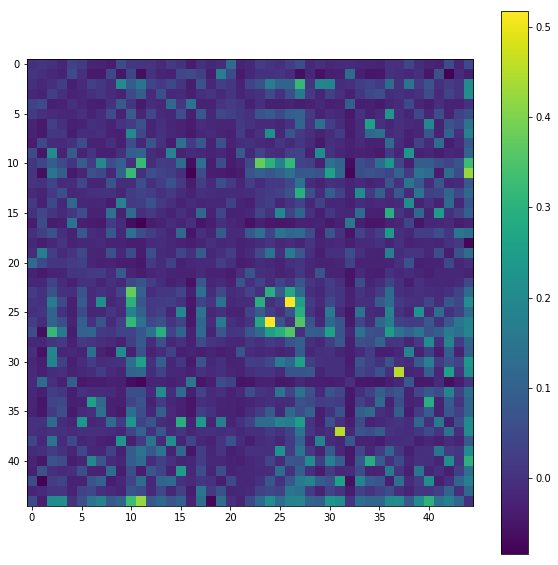

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 501
Average degree:  22.2667
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_None.graphml


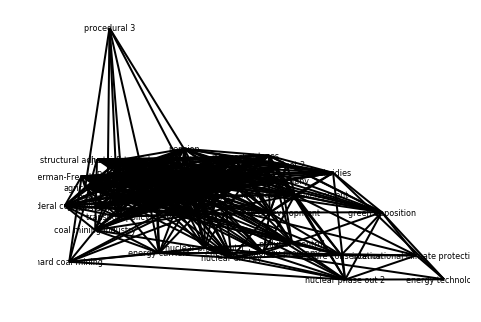

Calculating topic correlation for party spd and period None in run 2155
filtered docs * K: 114525
df shape: (114525, 3)


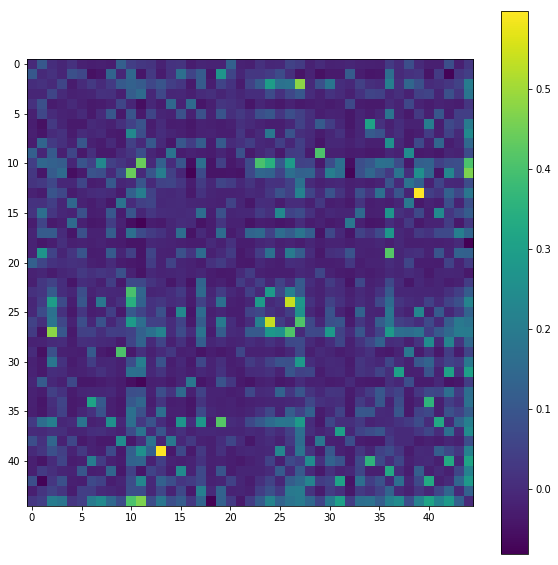

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 523
Average degree:  23.2444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_spd.graphml


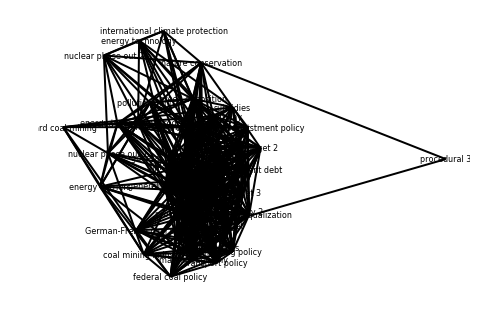

Calculating topic correlation for party cducsu and period None in run 2155
filtered docs * K: 145035
df shape: (145035, 3)


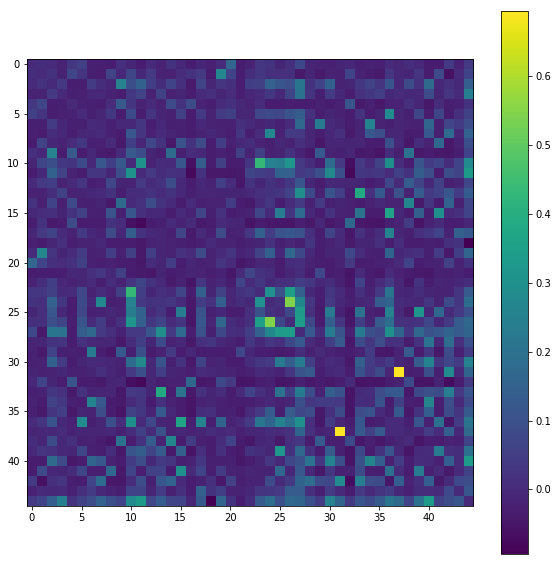

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 491
Average degree:  21.8222
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_cducsu.graphml


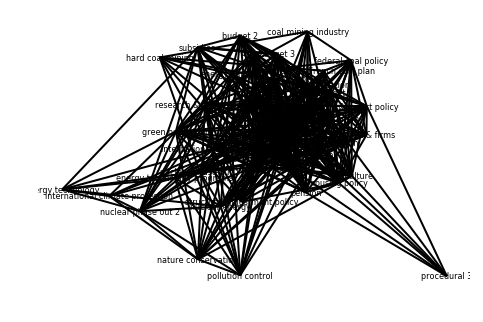

Calculating topic correlation for party fdp and period None in run 2155
filtered docs * K: 66645
df shape: (66645, 3)


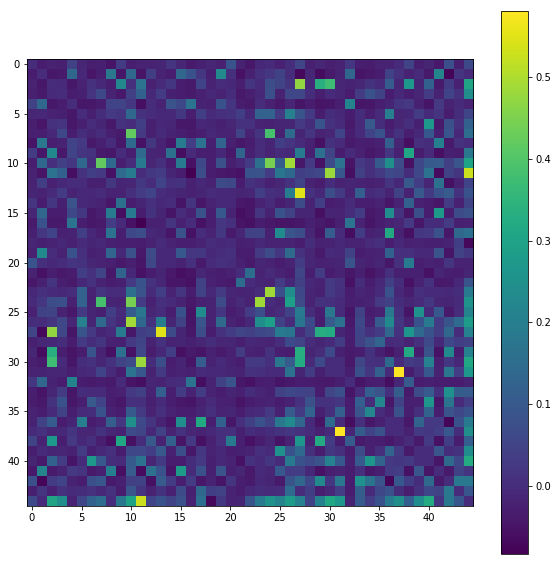

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 447
Average degree:  19.8667
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_fdp.graphml


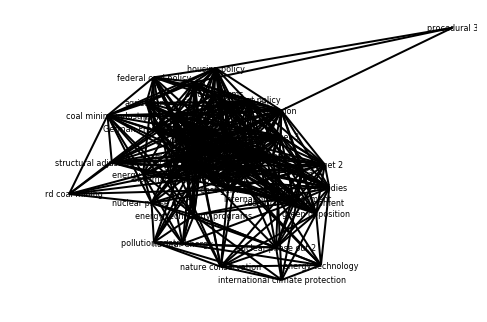

Calculating topic correlation for party linke and period None in run 2155
filtered docs * K: 18720
df shape: (18720, 3)


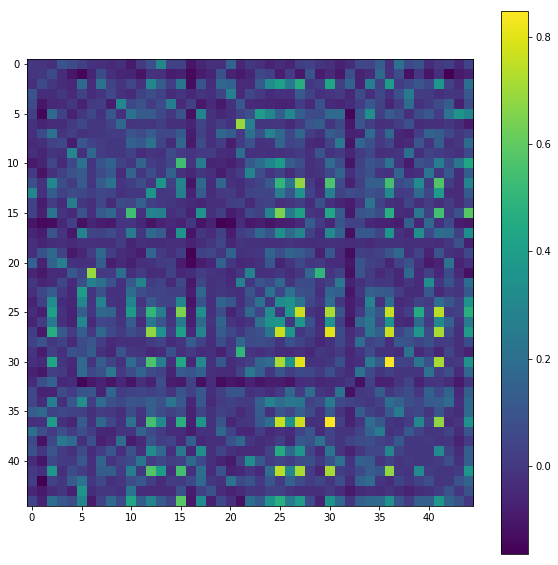

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 559
Average degree:  24.8444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_linke.graphml


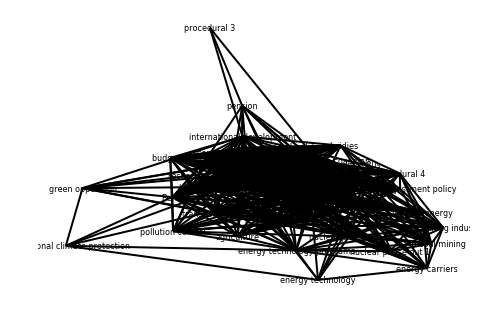

Calculating topic correlation for party gruene and period None in run 2155
filtered docs * K: 44235
df shape: (44235, 3)


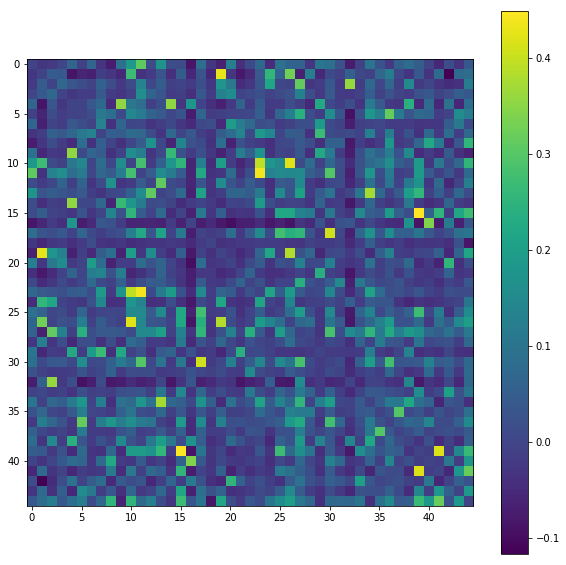

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 586
Average degree:  26.0444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_gruene.graphml


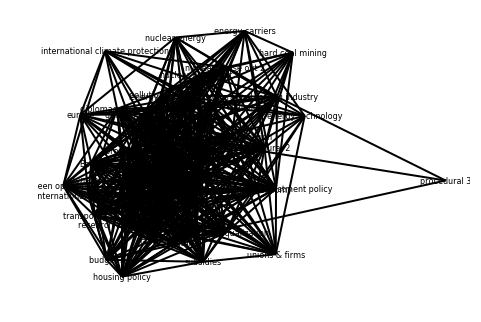

Calculating topic correlation for party afd and period None in run 2155
filtered docs * K: 3195
df shape: (3195, 3)


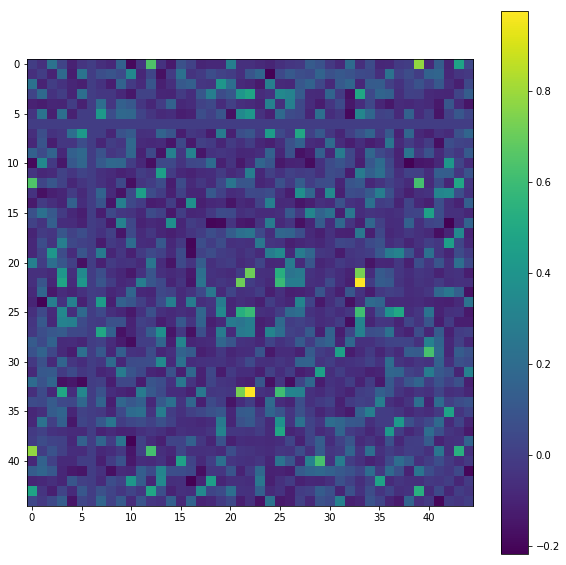

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 427
Average degree:  18.9778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_party_afd.graphml


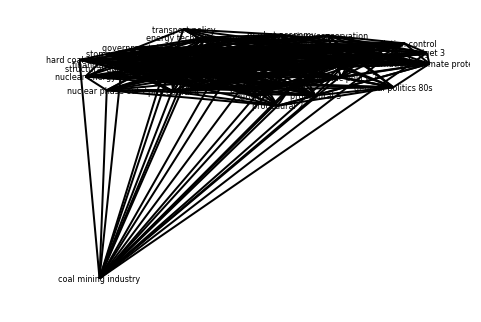

In [7]:
# generate graphs for parties

new_labels = False
threshold0 = True

for party_name in [None, 'spd', 'cducsu', 'fdp', 'linke', 'gruene', 'afd']:

    corr = corr_topics(run_id, party_name=party_name)
    
    show_matrix(corr.replace(to_replace=1, value=0))

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    if party_name:
        scores = {}
        topic_labels = nx.get_node_attributes(G, 'label')
        for node_id, topic_label in topic_labels.items():
            scores[node_id] = float(df_party_scores[topic_label][party_name])
            
        nx.set_node_attributes(G, scores, 'totalscores') 

    if new_labels:
        node_labels = {}
        topic_ids = nx.get_node_attributes(G, 'id')
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
        
        nx.set_node_attributes(G, node_labels, 'label') 
        
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_party_{}.graphml'.format(run_id, party_name))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))
    
    show_graph(G)

Calculating topic correlation for party None and period 1 in run 2155
filtered docs * K: 412515
df shape: (28125, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 541
Average degree:  24.0444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_1.graphml


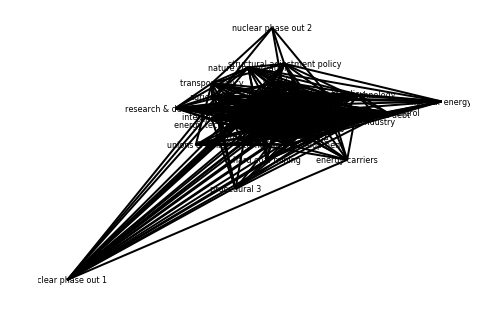

Calculating topic correlation for party None and period 2 in run 2155
filtered docs * K: 412515
df shape: (12870, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 541
Average degree:  24.0444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_2.graphml


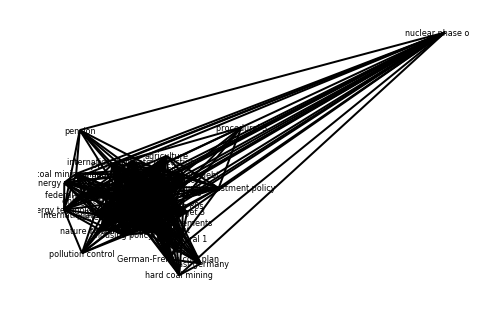

Calculating topic correlation for party None and period 3 in run 2155
filtered docs * K: 412515
df shape: (12960, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 588
Average degree:  26.1333
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_3.graphml


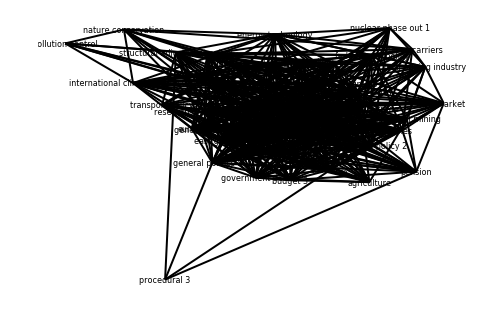

Calculating topic correlation for party None and period 4 in run 2155
filtered docs * K: 412515
df shape: (10620, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 538
Average degree:  23.9111
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_4.graphml


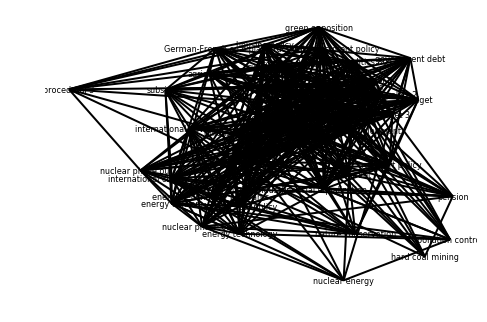

Calculating topic correlation for party None and period 5 in run 2155
filtered docs * K: 412515
df shape: (22770, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 657
Average degree:  29.2000
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_5.graphml


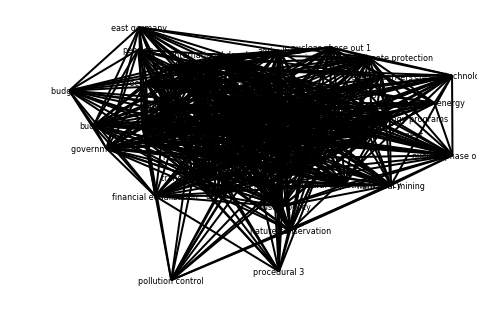

Calculating topic correlation for party None and period 6 in run 2155
filtered docs * K: 412515
df shape: (7065, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 574
Average degree:  25.5111
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_6.graphml


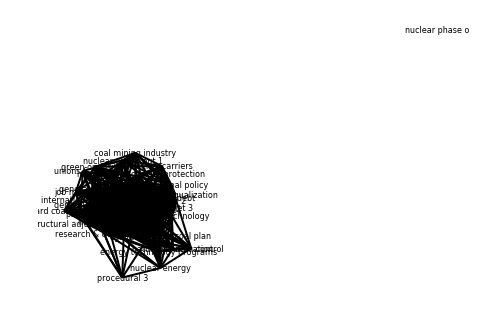

Calculating topic correlation for party None and period 7 in run 2155
filtered docs * K: 412515
df shape: (15975, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 625
Average degree:  27.7778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_7.graphml


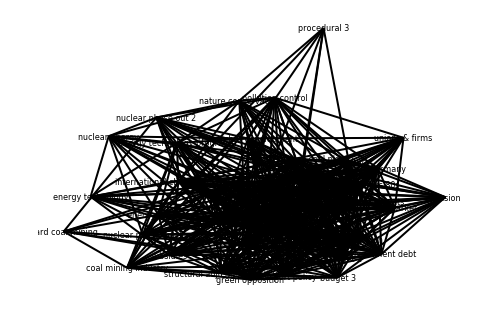

Calculating topic correlation for party None and period 8 in run 2155
filtered docs * K: 412515
df shape: (25200, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 634
Average degree:  28.1778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_8.graphml


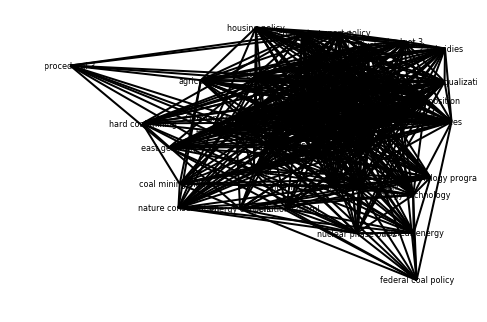

Calculating topic correlation for party None and period 9 in run 2155
filtered docs * K: 412515
df shape: (13950, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 579
Average degree:  25.7333
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_9.graphml


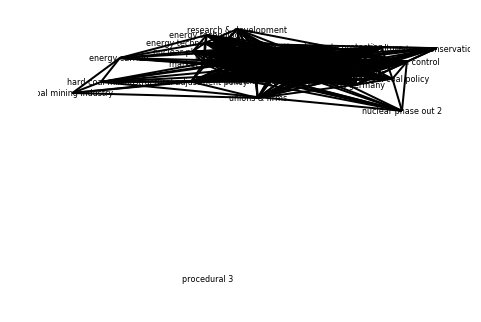

Calculating topic correlation for party None and period 10 in run 2155
filtered docs * K: 412515
df shape: (33930, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 604
Average degree:  26.8444
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_10.graphml


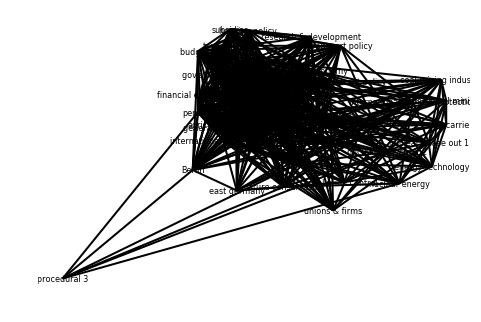

Calculating topic correlation for party None and period 11 in run 2155
filtered docs * K: 412515
df shape: (35730, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 615
Average degree:  27.3333
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_11.graphml


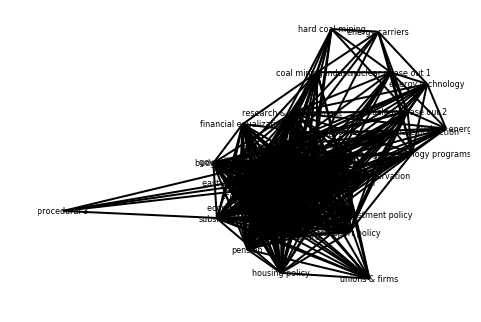

Calculating topic correlation for party None and period 12 in run 2155
filtered docs * K: 412515
df shape: (27675, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 580
Average degree:  25.7778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_12.graphml


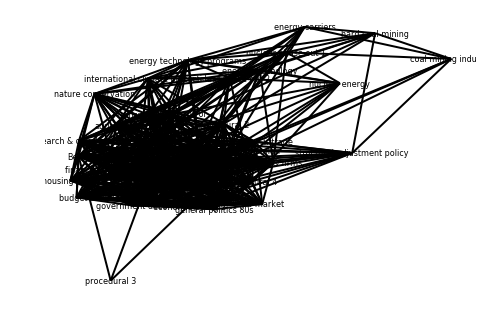

Calculating topic correlation for party None and period 13 in run 2155
filtered docs * K: 412515
df shape: (27495, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 516
Average degree:  22.9333
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_13.graphml


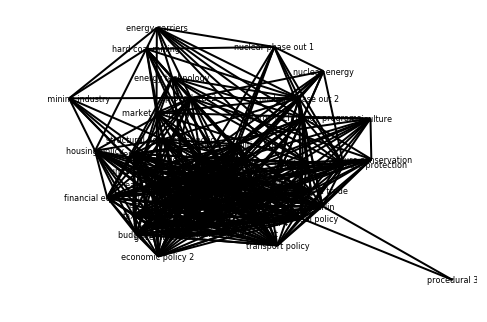

Calculating topic correlation for party None and period 14 in run 2155
filtered docs * K: 412515
df shape: (20970, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 603
Average degree:  26.8000
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_14.graphml


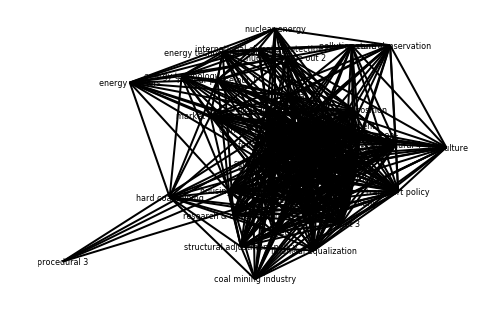

Calculating topic correlation for party None and period 15 in run 2155
filtered docs * K: 412515
df shape: (16605, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 498
Average degree:  22.1333
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_15.graphml


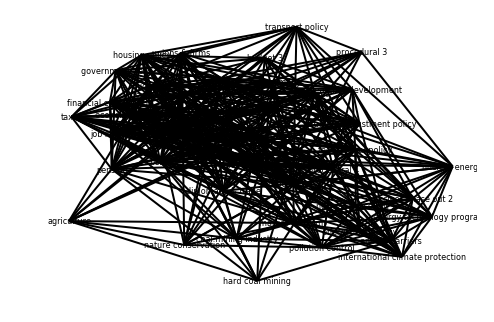

Calculating topic correlation for party None and period 16 in run 2155
filtered docs * K: 412515
df shape: (28620, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 517
Average degree:  22.9778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_16.graphml


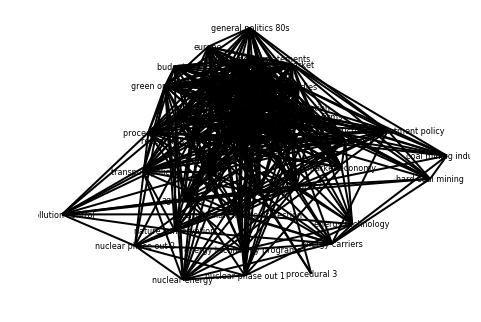

Calculating topic correlation for party None and period 17 in run 2155
filtered docs * K: 412515
df shape: (24660, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 512
Average degree:  22.7556
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_17.graphml


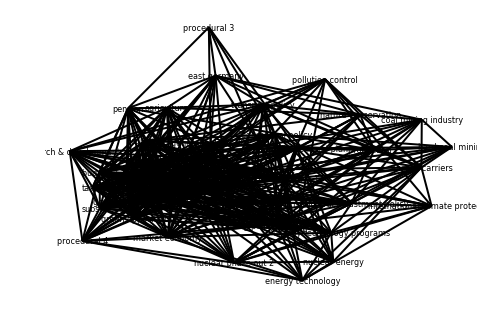

Calculating topic correlation for party None and period 18 in run 2155
filtered docs * K: 412515
df shape: (25830, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 518
Average degree:  23.0222
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_18.graphml


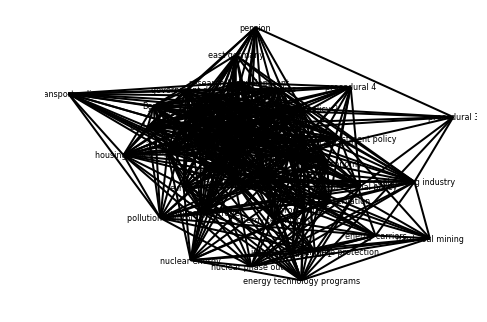

Calculating topic correlation for party None and period 19 in run 2155
filtered docs * K: 412515
df shape: (21465, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 499
Average degree:  22.1778
saved graph in ./topic_correlations/2155/topic_correlations_run2155_period_19.graphml


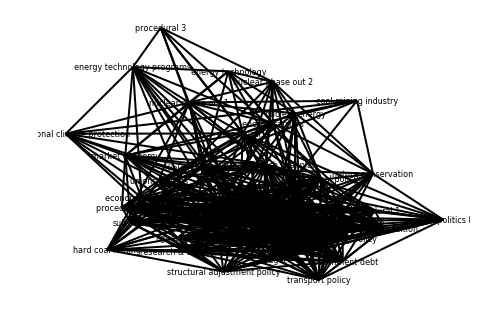

In [8]:
# generate graphs for parliamentary periods

for period in range(1,20):

    corr = corr_topics(run_id, period=period)

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][period])
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, period))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))
    
    show_graph(G)

# compress folder to easily download it

In [9]:
%%bash
zip -r topic_correlations/2155.zip topic_correlations/2155/

  adding: topic_correlations/2155/ (stored 0%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_1.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_party_gruene.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_9.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_6.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_7.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_16.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_15.graphml (deflated 81%)
  adding: topic_correlations/2155/topic_correlations_run2155_party_fdp.graphml (deflated 81%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_2.graphml (deflated 82%)
  adding: topic_correlations/2155/topic_correlations_run2155_period_10.graphml (deflated 82%)
  adding: topic

In [26]:
nx.get_node_attributes(G, 'label')

{0: 'targets',
 1: 'energy transition 3',
 2: 'power grid',
 3: 'procedural 3',
 4: 'electricity market',
 5: 'development',
 6: 'budget 2',
 7: 'energy transition 2',
 8: 'economy & jobs',
 9: 'conservation',
 10: 'nuclear',
 11: 'climate protection',
 12: 'mixed 3',
 13: 'regional policy',
 14: 'procedural 2',
 15: 'energy transition',
 16: 'economic policy',
 17: 'east germany',
 18: 'procedural 1',
 19: 'budget',
 20: 'mixed 2',
 21: 'climate policy',
 22: 'rail transport',
 23: 'finance',
 24: 'mixed 1',
 25: 'hard coal mining',
 26: 'gas production',
 27: 'biofuels',
 28: 'R&D',
 29: 'EU'}

Calculating topic correlation for spd in run 1739
filtered docs * K: 29520
df shape: (29520, 3)
threshold: 0.06944110454687229
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 80
Average degree:   4.0000


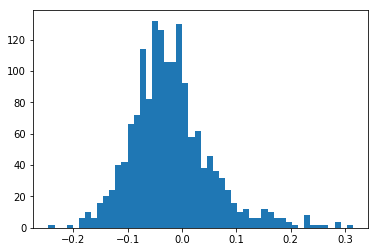

In [30]:
party_name = 'spd'
corr = party_corr_topics(1739, party_name)

threshold = corr_hist(corr, 90)

G = get_graph(corr, threshold)

#nx.write_graphml(G, 'topic_correlations_{}.graphml'.format(party_name))
#show_graph(G)

In [ ]:
# remove duplicates while preserving order

from collections import OrderedDict

terms = Term.objects.filter(topicterm__topic=topic).order_by('-topicterm__score').values('title', 'topicterm__score')[:stat.periods.all().count() * no_top_words]

odict = OrderedDict({})

for t in terms:
    if not t['title'] in odict.keys():
        odict[t['title']] = t['topicterm__score']

#list(OrderedDict.fromkeys(items))
print(odict)
print(len(odict))
